In [10]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy
from speech_segmentation import SpeechSegmentation

In [20]:
# Load segmentations from a specific trial
trial_number = "8016ef64-a243-11ec-b00d-acde48001122"
ss = SpeechSegmentation()
ss.load(f"../data/study3/vocalic_series/{trial_number}")

In [30]:
def point_series_from_segment_series(segment_series):
    """
    This function computes the mean and standard error in each segment for all the segments in
    a time series of segments
    """
    
    means = [np.mean(seg) for seg in segment_series]
    errs = [np.std(seg)/np.sqrt(len(seg)) for seg in segment_series]
    
    return means, errs

<ErrorbarContainer object of 3 artists>

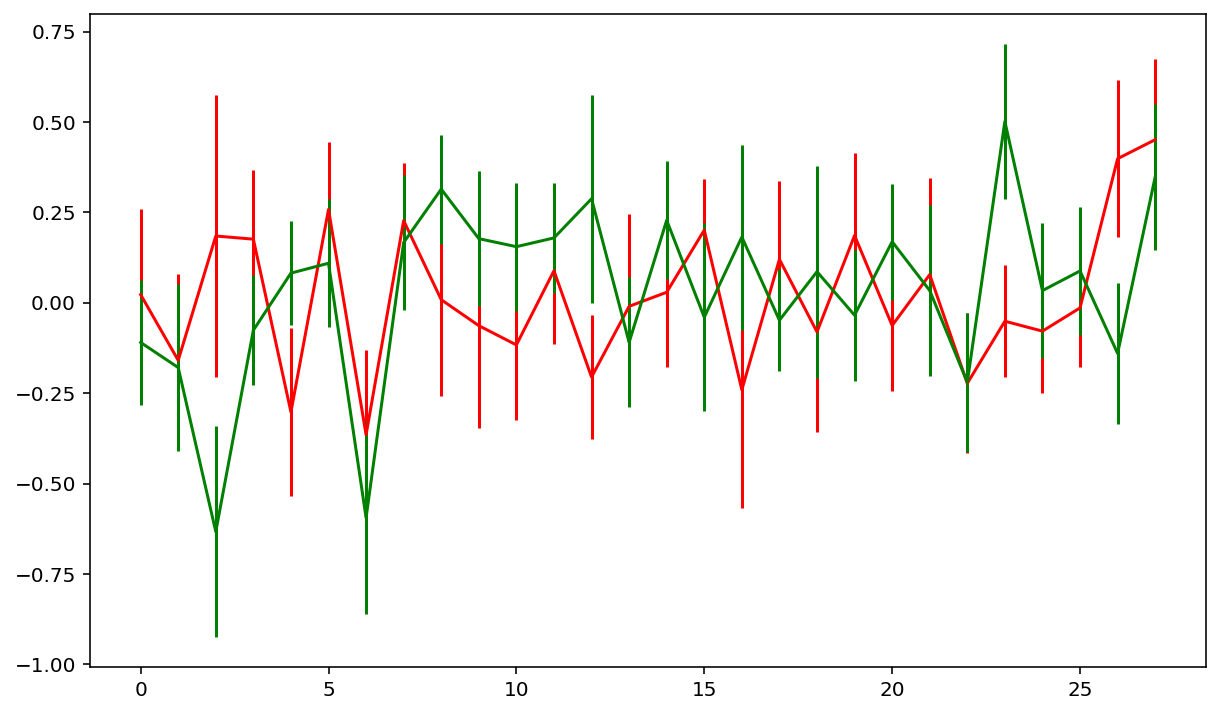

In [31]:
# Visualizing series for a specific dyad and vocalic feature
red_means, red_errs = point_series_from_segment_series(ss.red_to_green[0]["pitch"])
green_means, green_errs = point_series_from_segment_series(ss.red_to_green[1]["pitch"])
time_steps = np.arange(len(green_means))

plt.figure(figsize=(10, 6))
plt.errorbar(time_steps, red_means, yerr=red_errs, color="red")
plt.errorbar(time_steps, green_means, yerr=green_errs, color="green")

The plot above does not gives us much information. We are not interested in a point estimation but on the distribution of the vocalic features in each segmented utterance. 

Below, we explore tranfer entropy to compute the mutual information between vocalic segments of a source and a target player. We do this for every segment, which represent the vocalic features within each player's conversational turn.

That plot will carry more information. It will tell us how mutual information changes over time for a specific dyad, which might uncover points of phase transition (high entropy) and/or loss of coordination. 

In [32]:
def te_series_from_segment_series(source_segment_series, target_segment_series):
    """
    This function computes the mean and standard error of the tranfer entropy in each segment for all the segments in
    a time series of segments
    """
    
    means = []
    errs = []
    for i, source_segment in enumerate(source_segment_series):
        target_segment = target_segment_series[i]        
        te = transfer_entropy(source_segment, target_segment, k=1, local=True)
        means.append(np.mean(te))
        errs.append(np.std(te) / np.srqt(len(te)))
        
    return means, errs

In [ ]:
# Visualizing series of TE for a specific dyad and vocalic feature
te_means, te_errs = te_series_from_segment_series(ss.red_to_green[0]["pitch"], ss.red_to_green[1]["pitch"])
time_steps = np.arange(len(te_means))

plt.figure(figsize=(10, 6))
plt.errorbar(time_steps, te_means, yerr=te_errs, color="re)